In [68]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import load_npz
from src.files import InterProScanFile
from src.clusterer import Clusterer
import itertools
import seaborn as sns
import dataframe_image as dfi
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score, adjusted_rand_score

%load_ext autoreload
%autoreload 2

# TODO: Compare clustering in different dimensions using mutual information score, or some other similarity metric. 
# TODO: Do I need to rigorously-justify my choice of n_clusters? It was kind of arbitrary, kept it as the same order of magnitude as MMseqs
#   clustered at 50 percent sequence identity, but wanted a more tractable number of clusters for downstream analysis. 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
dims = 100
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
dataset_df = dataset_df.merge(pd.read_csv(f'../data/datasets/dataset_cluster_d{dims}.csv', index_col=0), left_index=True, right_index=True)

# matrix = alignment_to_csr_matrix('../data/datasets/dataset_dataset_align.tsv', index=dataset_df.index.values, chunk_size=50000)
matrix = load_npz('../data/datasets/dataset_dataset_align.npz')

In [76]:
def table_1(path:str='../figures/cluster-table_1.png'):

    # https://stats.stackexchange.com/questions/260487/adjusted-rand-index-vs-adjusted-mutual-information
    dims = [20, 50, 100, 1280]

    table_df = pd.DataFrame(columns=['n_singletons', 'adjusted_mutual_info_score', 'mean_cluster_size', 'max_cluster_size'], index=pd.Index(dims, name='dims'))

    reference_cluster_df = pd.read_csv(f'../data/datasets/dataset_cluster_d1280.csv', index_col=0)
    for dims_ in dims:
        cluster_df = pd.read_csv(f'../data/datasets/dataset_cluster_d{dims_}.csv', index_col=0)
        cluster_sizes = cluster_df.groupby('cluster_id').apply(len, include_groups=False)
        table_df.loc[dims_, 'n_singletons'] = (cluster_sizes == 1).sum()
        table_df.loc[dims_, 'mean_cluster_size'] = cluster_sizes.mean()
        table_df.loc[dims_, 'max_cluster_size'] = cluster_sizes.max()
        # table_df.loc[dims_, 'adjusted_rand_score'] = adjusted_rand_score(reference_cluster_df.cluster_id, cluster_df.cluster_id)
        table_df.loc[dims_, 'adjusted_mutual_info_score'] = adjusted_mutual_info_score(reference_cluster_df.cluster_id, cluster_df.cluster_id)
    return table_df

table_1()

# My clustering approach generates singleton clusters when it has a hard time separating spurious from real clusters, due to the 
# "largest_non_homogenous" bisecting condition. The fact that lower-dimensional space results in more singletons therefore means
# that PCA reduction loses some key features which help identify similar embeddings. 

,n_singletons,adjusted_mutual_info_score,mean_cluster_size,max_cluster_size
dims,,,,
20,2011,0.52578,27.659,70
50,1819,0.662237,27.659,69
100,1797,0.738001,27.659,71
1280,1794,1.0,27.659,75


In [65]:
def get_cluster_sequence_identities(dataset_df:pd.DataFrame, cluster_id:int, shuffle:bool=False):
    cluster_ids = dataset_df.cluster_id.values.copy()
    if shuffle:
        np.random.shuffle(cluster_ids)
    cluster_idxs = np.where(cluster_ids == cluster_id)[0]
    if len(cluster_idxs) == 1:
        return None
    return np.array([matrix[i, j] for i, j in itertools.combinations(cluster_idxs, 2)])


def get_figure_1_data(dataset_df:pd.DataFrame, path:str='../data/figures/cluster-figure_1.csv'):

    figure_df = list()
    
    n_clusters = dataset_df.cluster_id.nunique()
    for cluster_id in tqdm(range(n_clusters), 'get_figure_1_data: Computing alignment data for each cluster.'):
        row = {'cluster_id':cluster_id}
        sequence_identities = get_cluster_sequence_identities(dataset_df, cluster_id)
        if sequence_identities is not None:
            row.update({'mean_sequence_identity':sequence_identities.mean(), 'min_sequence_identity':sequence_identities.min(), 'max_sequence_identity':sequence_identities.max()})
        sequence_identities = get_cluster_sequence_identities(dataset_df, cluster_id, shuffle=True)
        if sequence_identities is not None:
            row.update({'mean_sequence_identity_baseline':sequence_identities.mean(), 'min_sequence_identity_baseline':sequence_identities.min(), 'max_sequence_baseline':sequence_identities.max()})
        figure_df.append(row)

    figure_df = pd.DataFrame(figure_df).set_index('cluster_id')
    figure_df.to_csv(path)

get_figure_1_data(dataset_df)

get_figure_1_data: Computing alignment data for each cluster.: 100%|██████████| 10000/10000 [05:19<00:00, 31.34it/s]


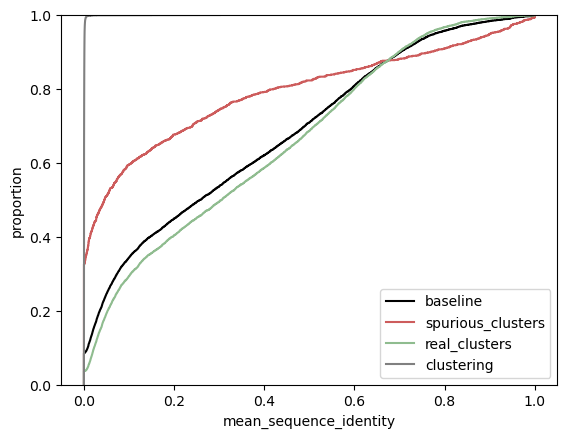

In [77]:
def figure_1(dataset_df:pd.DataFrame, path:str=None):

    fig, ax = plt.subplots()

    ax_df = pd.read_csv('../data/figures/cluster-figure_1.csv', index_col=0)
    ax_df['label'] = dataset_df.groupby('cluster_id').label.first()

    sns.ecdfplot(x=ax_df.mean_sequence_identity, color='black', ax=ax, label='baseline')
    sns.ecdfplot(x=ax_df[ax_df.label == 0].mean_sequence_identity, color='indianred', ax=ax, label='spurious_clusters')
    sns.ecdfplot(x=ax_df[ax_df.label == 1].mean_sequence_identity, color='darkseagreen', ax=ax, label='real_clusters')
    sns.ecdfplot(x=ax_df.mean_sequence_identity_baseline, color='gray', ax=ax, label='clustering')
    ax.legend()
    ax.set_ylabel('proportion')
    plt.show()

figure_1(dataset_df)



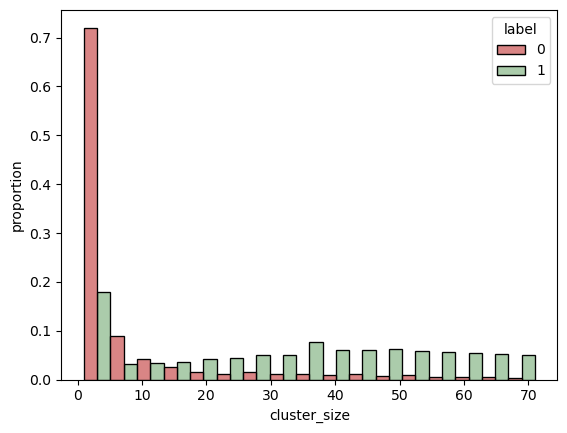

In [79]:
def figure(dataset_df:pd.DataFrame):
    fig, ax = plt.subplots()

    ax_df = pd.DataFrame(index=pd.Index(dataset_df.cluster_id.unique(), name='cluster_id'))
    ax_df['cluster_size'] = dataset_df.groupby('cluster_id').apply(len, include_groups=False)
    ax_df['label'] = dataset_df.groupby('cluster_id').label.first()

    palette = {0:'indianred', 1:'darkseagreen'}
    sns.histplot(data=ax_df, hue='label', ax=ax, palette=palette, x='cluster_size', multiple='dodge', stat='proportion', common_norm=False) # , binwidth=0.5)
    # sns.histplot(data=ax_df, hue='label', ax=ax, palette=palette, x='cluster_size', multiple='dodge', stat='count', common_norm=False) # , binwidth=0.5)
    ax.set_ylabel('proportion')

    plt.show()

figure(dataset_df)